In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import precision_recall_fscore_support as scores
from statistics import variance
import matplotlib.pyplot as plt

import psycopg2
import pandas.io.sql as sqlio
import psycopg2.extras


In [2]:
# Establish a connection to the PLUTO database
try:
    conn = psycopg2.connect("dbname='pluto' user='oliver' host='localhost' password='m'")
except:
    print("I am unable to connect to the database")

# Create a cursor object for executing queries
conn.autocommit = True
cur = conn.cursor()

In [4]:
    cov_forest = [
    'xcoord'
    ,'ycoord'
    ,'age'
    ,'build_alter_gap'
    ,'alterage'      
    ,'elevator'
    ,'commercial'
    ,'garage'
    ,'storage'
    ,'basement'
    ,'waterfront'
    ,'frontage'
    ,'block_assmeblage'
    ,'cooperative'
    ,'conv_loft_wh'
    ,'tenament'
    ,'garden'
    ,'semi_fireproof'
    ,'fireproof'
    ,'luxury'
    ,'artist_res'
    ,'units_per_building'
    ,'floors'
    ,'zip_avg_num_buildings'
    ,'pcvpu_l1'
    ,'pcvpu_l2'
    ,'pcvpu_l3'
    ,'avg_block_pcvpu_l1'
    ,'avg_block_pcvpu_l2'
    ,'avg_block_pcvpu_l3'
    ,'avg_neighbor1_pcvpu_l1'
    ,'avg_neighbor1_pcvpu_l2'
    ,'avg_neighbor1_pcvpu_l3'
    ,'avg_neighbor2_pcvpu_l1'
    ,'avg_neighbor2_pcvpu_l2'
    ,'avg_neighbor2_pcvpu_l3'
    ,'avg_neighbor3_pcvpu_l1'
    ,'avg_neighbor3_pcvpu_l2'
    ,'avg_neighbor3_pcvpu_l3'
    ,'avg_neighbor4_pcvpu_l1'
    ,'avg_neighbor4_pcvpu_l2'
    ,'avg_neighbor4_pcvpu_l3'
    ,'avg_zip_pcvpu_l1'
    ,'avg_zip_pcvpu_l2'
    ,'avg_zip_pcvpu_l3'
    ]

In [5]:
# Commands to select data from each year
sql_2008 = """SELECT * 
         FROM pluto_disc
         WHERE year = 2008
         """
sql_2009 = """SELECT * 
         FROM pluto_disc
         WHERE year = 2009
         """
sql_2010 = """SELECT * 
         FROM pluto_disc
         WHERE year = 2010
         """
sql_2010 = """SELECT * 
         FROM pluto_disc
         WHERE year = 2010
         """
sql_2011 = """SELECT * 
         FROM pluto_disc
         WHERE year = 2011
         """
sql_2012 = """SELECT * 
         FROM pluto_disc
         WHERE year = 2012
         """
sql_2013 = """SELECT * 
         FROM pluto_disc
         WHERE year = 2013
         """
sql_2014 = """SELECT * 
         FROM pluto_disc
         WHERE year = 2014
         """
sql_2015 = """SELECT * 
         FROM pluto_disc
         WHERE year = 2015
         """
sql_2016 = """SELECT * 
         FROM pluto_disc
         WHERE year = 2016
         """
sql_2017 = """SELECT * 
         FROM pluto_disc
         WHERE year = 2017
         """
sql_2018 = """SELECT * 
         FROM pluto_disc
         WHERE year = 2018
         """
sql_2019 = """SELECT * 
         FROM pluto_disc
         WHERE year = 2019
         """
sql_2020 = """SELECT * 
         FROM pluto_disc
         WHERE year = 2020
         """

In [6]:
# Function for creating dataframes from a SQL query
def get_data(sql_train, sql_test, cov_forest):
    """
    Function to return data from a train and test SQL query
    """
    global df_train, df_test, X_train, X_test, y_train, y_test, covariates

    # List of columns to be used as covariates in the model

    df_train = sqlio.read_sql_query(sql_train, conn).dropna()
    df_test = sqlio.read_sql_query(sql_test, conn).dropna()

    covariates = df_train.columns.intersection(cov_forest)

    X_train = df_train[covariates]
    y_train = df_train['pcvpu_target']

    X_test = df_test[covariates]
    y_test = df_test['pcvpu_target']
    return df_train, df_test, X_train, X_test, y_train, y_test

In [7]:
# Create a random forest classifier object
# warm_start = True allows the model to be trained on new data without having to retrain the entire model
gbc = XGBClassifier(n_estimators=100, max_depth=5, eta=0.03, random_state=0)

In [8]:
# Set up empty lists to store the results of the model for each year

MAEs = [] ## Mean Absolute Error, list of numbers (out of sample)
R2s = []  ## R2 score, list of numbers (out of sample)
accuracies = [] ## Accuracy, list of numbers (out of sample)
precisions = [] ## Precision scores for each class, list of lists (out of sample)
recalls = [] ## Recall scores for each class, list of lists (out of sample)
f1scores = [] ## F1 score for each class, list of lists (out of sample)
supports = [] ## Support scores for each class, list of lists (out of sample)

feature_importances = [] ## Feature importances, list of lists

MAEs_in_sample = [] ## Mean Absolute Error, list of numbers (in sample)
R2s_in_sample = []  ## R2 score, list of numbers (in sample)
accuracies_in_sample = [] ## Accuracy, list of numbers (in sample)
precisions_in_sample = [] ## Precision scores for each class, list of lists (in sample)
recalls_in_sample = [] ## Recall scores for each class, list of lists (in sample)
f1scores_in_sample = [] ## F1 score for each class, list of lists (in sample)
supports_in_sample = [] ## Support scores for each class, list of lists (in sample)

def update_reports():
    """
    Function to update the reports for each year
    """
    print('Updating Out of Sample Reports')
    print(classification_report(y_test, y_pred))
    precision, recall, f1score, support = scores(y_test, y_pred)
    precisions.append(precision)
    recalls.append(recall)
    f1scores.append(f1score)
    supports.append(support)
    accuracies.append(accuracy_score(y_test, y_pred))
    MAEs.append(mean_absolute_error(y_test, y_pred))
    R2s.append(r2_score(y_test, y_pred))

    print('Updating In Sample Reports')
    print(classification_report(y_train, y_pred_in_sample))
    precision_in_sample, recall_in_sample ,f1score_in_sample, support_in_sample = scores(y_train, y_pred_in_sample)
    precisions_in_sample.append(precision_in_sample)
    recalls_in_sample.append(recall_in_sample)
    f1scores_in_sample.append(f1score_in_sample)
    supports_in_sample.append(support_in_sample)
    accuracies_in_sample.append(accuracy_score(y_train, y_pred_in_sample))
    MAEs_in_sample.append(mean_absolute_error(y_train, y_pred_in_sample))
    R2s_in_sample.append(r2_score(y_train, y_pred_in_sample))

    print('Updating Feature Importances')
    feature_importances.append(pd.Series(gbc.feature_importances_, index=cov_forest))


In [9]:
# get data from 2008 and 2009
df_train, df_test, X_train, X_test, y_train, y_test = get_data(sql_2008, sql_2009, cov_forest)


In [12]:
# fit the model for 2008 and 2009
gbc.fit(X_train,y_train)
gbc.save_model('pluto-10-03-2b--y2008-2009.model')

/home/oliver/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:35:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [13]:
# Make in and out of sample predictions
y_pred = gbc.predict(X_test)
y_pred_in_sample = gbc.predict(X_train)

In [14]:
# update all the report series
update_reports()

Updating Out of Sample Reports
              precision    recall  f1-score   support

           0       0.61      0.71      0.66     19654
           1       0.78      0.78      0.78     56098
           2       0.83      0.83      0.83     63793
           3       0.31      0.09      0.14      5531

    accuracy                           0.77    145076
   macro avg       0.63      0.60      0.60    145076
weighted avg       0.76      0.77      0.76    145076

Updating In Sample Reports
              precision    recall  f1-score   support

           0       0.60      0.78      0.68     16031
           1       0.82      0.73      0.78     45689
           2       0.87      0.91      0.89     75018
           3       0.43      0.22      0.29      6601

    accuracy                           0.81    143339
   macro avg       0.68      0.66      0.66    143339
weighted avg       0.81      0.81      0.80    143339

Updating Feature Importances


In [15]:
# get data for the next year
df_train, df_test, X_train, X_test, y_train, y_test = get_data(sql_2009, sql_2010, cov_forest)

In [16]:
# expand the number of trees and then fit to the next year
gbc.fit(X_train,y_train, xgb_model='pluto-10-03-2b--y2008-2009.model')
gbc.save_model('pluto-10-03-2b--y2009-2010.model')

/home/oliver/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:37:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [17]:
y_pred = gbc.predict(X_test)
y_pred_in_sample = gbc.predict(X_train)

In [18]:
# update all the report series
update_reports()

Updating Out of Sample Reports
              precision    recall  f1-score   support

           0       0.27      0.51      0.35     14026
           1       0.83      0.73      0.78     65196
           2       0.70      0.78      0.74     56957
           3       0.46      0.06      0.10     12673

    accuracy                           0.67    148852
   macro avg       0.57      0.52      0.49    148852
weighted avg       0.70      0.67      0.67    148852

Updating In Sample Reports
              precision    recall  f1-score   support

           0       0.64      0.79      0.71     19654
           1       0.84      0.80      0.82     56098
           2       0.86      0.88      0.87     63793
           3       0.39      0.17      0.23      5531

    accuracy                           0.81    145076
   macro avg       0.68      0.66      0.66    145076
weighted avg       0.81      0.81      0.81    145076

Updating Feature Importances


In [19]:
# get data for the next year
df_train, df_test, X_train, X_test, y_train, y_test = get_data(sql_2010, sql_2011, cov_forest)

# expand the number of trees and then fit to the next year
gbc.fit(X_train,y_train, xgb_model='pluto-y10-03-2b--2009-2010.model')
gbc.save_model('pluto-y10-03-2b--2010-2011.model')

y_pred = gbc.predict(X_test)
y_pred_in_sample = gbc.predict(X_train)

# update all the report series
update_reports()

/home/oliver/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:40:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Updating Out of Sample Reports
              precision    recall  f1-score   support

           0       0.28      0.22      0.24     15426
           1       0.94      0.32      0.48    128361
           2       0.01      0.14      0.01      3039
           3       0.11      0.57      0.18      3339

    accuracy                           0.31    150165
   macro avg       0.33      0.31      0.23    150165
weighted avg       0.83      0.31      0.44    150165

Updating In Sample Reports
              precision    recall  f1-score   support

           0       0.48      0.33      0.39     14026
           1       0.89      0.85      0.87     65196
           2       0.80      0.82      0.81     56957
           3       0.50      0.72    

In [21]:
# get data for the next year
df_train, df_test, X_train, X_test, y_train, y_test = get_data(sql_2011, sql_2012, cov_forest)

# expand the number of trees and then fit to the next year
gbc.fit(X_train,y_train, xgb_model='pluto-10-03-2b--y2010-2011.model')
gbc.save_model('pluto-10-03-2b--y2011-2012.model')

y_pred = gbc.predict(X_test)
y_pred_in_sample = gbc.predict(X_train)

# update all the report series
update_reports()

[23:00:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Updating Out of Sample Reports
              precision    recall  f1-score   support

           0       0.20      0.13      0.16     11697
           1       0.34      0.95      0.50     51325
           2       0.22      0.00      0.00     77885
           3       0.29      0.01      0.01     10654

    accuracy                           0.33    151561
   macro avg       0.26      0.27      0.17    151561
weighted avg       0.26      0.33      0.18    151561

Updating In Sample Reports
              precision    recall  f1-score   support

           0       0.54      0.28      0.37     15426
           1       0.89      0.98      0.93    128361
           2       0.23      0.01      0.02      3039
           3       0.55      0.06    

In [23]:
# get data for the next year
df_train, df_test, X_train, X_test, y_train, y_test = get_data(sql_2012, sql_2013, cov_forest)

# expand the number of trees and then fit to the next year
gbc.fit(X_train,y_train, xgb_model='pluto-10-03-2b--y2011-2012.model')
gbc.save_model('pluto-10-03-2b--y2012-2013.model')

y_pred = gbc.predict(X_test)
y_pred_in_sample = gbc.predict(X_train)

# update all the report series
update_reports()

[23:03:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Updating Out of Sample Reports
              precision    recall  f1-score   support

           0       0.25      0.16      0.19     14892
           1       0.60      0.67      0.63     50865
           2       0.74      0.80      0.77     74913
           3       0.43      0.18      0.25     12179

    accuracy                           0.65    152849
   macro avg       0.50      0.45      0.46    152849
weighted avg       0.62      0.65      0.63    152849

Updating In Sample Reports
              precision    recall  f1-score   support

           0       0.56      0.33      0.42     11697
           1       0.73      0.76      0.75     51325
           2       0.82      0.86      0.84     77885
           3       0.72      0.65    

In [24]:
# get data for the next year
df_train, df_test, X_train, X_test, y_train, y_test = get_data(sql_2013, sql_2014, cov_forest)
# expand the number of trees and then fit to the next year
gbc.fit(X_train,y_train , xgb_model='pluto-10-03-2b--y2012-2013.model')
gbc.save_model('pluto-10-03-2b--y2013-2014.model')
# make predictions for the next year
y_pred = gbc.predict(X_test)
y_pred_in_sample = gbc.predict(X_train)
# update all the report series
update_reports()

/home/oliver/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:06:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Updating Out of Sample Reports
              precision    recall  f1-score   support

           0       0.08      0.25      0.12      3813
           1       0.75      0.68      0.71     62233
           2       0.78      0.74      0.76     71827
           3       0.51      0.54      0.52     15432

    accuracy                           0.68    153305
   macro avg       0.53      0.55      0.53    153305
weighted avg       0.72      0.68      0.70    153305

Updating In Sample Reports
              precision    recall  f1-score   support

           0       0.50      0.36      0.42     14892
           1       0.80      0.69      0.74     50865
           2       0.81      0.87      0.84     74913
           3       0.46      0.66    

In [25]:
# get data for the next year
df_train, df_test, X_train, X_test, y_train, y_test = get_data(sql_2014, sql_2015, cov_forest)
# expand the number of trees and then fit to the next year
gbc.fit(X_train,y_train, xgb_model='pluto-10-03-2b--y2013-2014.model')
gbc.save_model('pluto-10-03-2b--y2014-2015.model')
# make predictions for the next year
y_pred = gbc.predict(X_test)
y_pred_in_sample = gbc.predict(X_train)
# update all the report series
update_reports()

/home/oliver/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:08:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Updating Out of Sample Reports
              precision    recall  f1-score   support

           0       0.20      0.06      0.09      8551
           1       0.77      0.84      0.80     67924
           2       0.82      0.74      0.78     63672
           3       0.44      0.66      0.53     13906

    accuracy                           0.74    154053
   macro avg       0.56      0.57      0.55    154053
weighted avg       0.73      0.74      0.73    154053

Updating In Sample Reports
              precision    recall  f1-score   support

           0       0.30      0.05      0.09      3813
           1       0.85      0.77      0.81     62233
           2       0.82      0.82      0.82     71827
           3       0.51      0.82    

In [26]:
# get data for the next year
df_train, df_test, X_train, X_test, y_train, y_test = get_data(sql_2015, sql_2016, cov_forest)
# expand the number of trees and then fit to the next year
gbc.fit(X_train,y_train, xgb_model='pluto-10-03-2b--y2014-2015.model')
gbc.save_model('pluto-10-03-2b--y2015-2016.model')
# make predictions for the next year
y_pred = gbc.predict(X_test)
y_pred_in_sample = gbc.predict(X_train)
# update all the report series
update_reports()

/home/oliver/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:09:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Updating Out of Sample Reports
              precision    recall  f1-score   support

           0       0.16      0.06      0.08      5262
           1       0.83      0.72      0.77     56597
           2       0.86      0.85      0.85     81847
           3       0.36      0.76      0.49     11251

    accuracy                           0.76    154957
   macro avg       0.55      0.59      0.55    154957
weighted avg       0.79      0.76      0.77    154957

Updating In Sample Reports
              precision    recall  f1-score   support

           0       0.37      0.10      0.15      8551
           1       0.87      0.82      0.84     67924
           2       0.84      0.85      0.85     63672
           3       0.46      0.77    

In [27]:
# get data for the next year
df_train, df_test, X_train, X_test, y_train, y_test = get_data(sql_2016, sql_2017, cov_forest)
# expand the number of trees and then fit to the next year
gbc.fit(X_train,y_train, xgb_model='pluto-10-03-2b--y2015-2016.model')
gbc.save_model('pluto-10-03-2b--y2016-2017.model')
# make predictions for the next year
y_pred = gbc.predict(X_test)
y_pred_in_sample = gbc.predict(X_train)
# update all the report series
update_reports()

/home/oliver/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:11:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Updating Out of Sample Reports
              precision    recall  f1-score   support

           0       0.14      0.02      0.03      4667
           1       0.78      0.72      0.75     57630
           2       0.84      0.86      0.85     81767
           3       0.34      0.53      0.42     11150

    accuracy                           0.76    155214
   macro avg       0.52      0.53      0.51    155214
weighted avg       0.76      0.76      0.76    155214

Updating In Sample Reports
              precision    recall  f1-score   support

           0       0.33      0.05      0.08      5262
           1       0.79      0.76      0.78     56597
           2       0.86      0.87      0.86     81847
           3       0.40      0.60    

In [28]:
# get data for the next year
df_train, df_test, X_train, X_test, y_train, y_test = get_data(sql_2017, sql_2018, cov_forest)
# expand the number of trees and then fit to the next year
gbc.fit(X_train,y_train, xgb_model='pluto-10-03-2b--y2016-2017.model')
gbc.save_model('pluto-10-03-2b--y2017-2018.model')
# make predictions for the next year
y_pred = gbc.predict(X_test)
y_pred_in_sample = gbc.predict(X_train)
# update all the report series
update_reports()

/home/oliver/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:13:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Updating Out of Sample Reports
              precision    recall  f1-score   support

           0       0.99      0.00      0.01     90097
           1       0.02      0.34      0.03      2978
           2       0.02      0.66      0.04      2722
           3       0.01      0.00      0.00     54260

    accuracy                           0.02    150057
   macro avg       0.26      0.25      0.02    150057
weighted avg       0.60      0.02      0.01    150057

Updating In Sample Reports
              precision    recall  f1-score   support

           0       0.37      0.02      0.04      4667
           1       0.76      0.79      0.78     57630
           2       0.86      0.87      0.86     81767
           3       0.41      0.47    

In [29]:
# get data for the next year
df_train, df_test, X_train, X_test, y_train, y_test = get_data(sql_2018, sql_2019, cov_forest)
# expand the number of trees and then fit to the next year
gbc.fit(X_train,y_train, xgb_model='pluto-10-03-2b--y2017-2018.model')
gbc.save_model('pluto-10-03-2b--y2018-2019.model')
# make predictions for the next year
y_pred = gbc.predict(X_test)
y_pred_in_sample = gbc.predict(X_train)
# update all the report series
update_reports()

/home/oliver/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:14:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Updating Out of Sample Reports
              precision    recall  f1-score   support

           0       0.24      0.70      0.36     35174
           1       0.09      0.00      0.00     33758
           2       0.26      0.00      0.01     26029
           3       0.46      0.40      0.43     55470

    accuracy                           0.31    150431
   macro avg       0.26      0.28      0.20    150431
weighted avg       0.29      0.31      0.24    150431

Updating In Sample Reports
              precision    recall  f1-score   support

           0       0.91      0.92      0.92     90097
           1       0.13      0.01      0.01      2978
           2       0.30      0.02      0.04      2722
           3       0.83      0.90    

In [30]:
# get data for the next year
df_train, df_test, X_train, X_test, y_train, y_test = get_data(sql_2019, sql_2020, cov_forest)
# expand the number of trees and then fit to the next year
gbc.fit(X_train,y_train, xgb_model='pluto-10-03-2b--y2018-2019.model')
gbc.save_model('pluto-10-03-2b--y2019-2020.model')
# make predictions for the next year
y_pred = gbc.predict(X_test)
y_pred_in_sample = gbc.predict(X_train)
# update all the report series
update_reports()

/home/oliver/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:16:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Updating Out of Sample Reports
              precision    recall  f1-score   support

           0       0.67      0.58      0.62    100812
           1       0.08      0.01      0.02     28247
           2       0.09      0.03      0.04      8548
           3       0.08      0.36      0.14     13573

    accuracy                           0.42    151180
   macro avg       0.23      0.24      0.21    151180
weighted avg       0.48      0.42      0.43    151180

Updating In Sample Reports
              precision    recall  f1-score   support

           0       0.37      0.42      0.39     35174
           1       0.42      0.36      0.38     33758
           2       0.32      0.11      0.17     26029
           3       0.50      0.66    

Text(0.5, 1.0, 'Accuracy Score by Year')

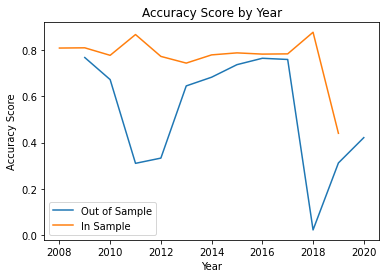

In [31]:
years = [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
years_in_sample = [2008 ,2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
plt.plot(years, accuracies, label='Out of Sample')
plt.plot(years_in_sample, accuracies_in_sample, label='In Sample')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Score by Year')

Text(0.5, 1.0, 'Out of Sample F1 Scores by Year')

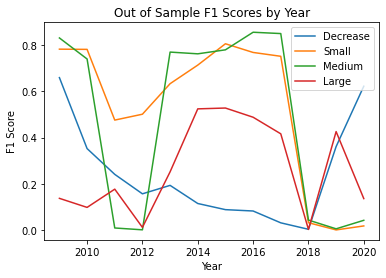

In [32]:
plt.plot(years, f1scores)
plt.legend(['Decrease','Small','Medium','Large'])
plt.xlabel('Year')
plt.ylabel('F1 Score')
plt.title('Out of Sample F1 Scores by Year')

Text(0.5, 1.0, 'In Sample F1 Scores by Year')

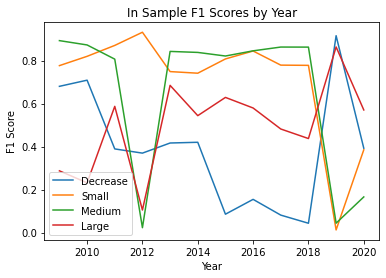

In [33]:
plt.plot(years, f1scores_in_sample)
plt.legend(['Decrease','Small','Medium','Large'])
plt.xlabel('Year')
plt.ylabel('F1 Score')
plt.title('In Sample F1 Scores by Year')

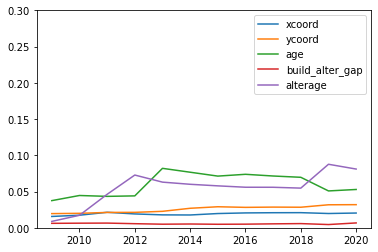

In [34]:
plt.axis([None, None, 0, 0.3])
plt.plot(years, [feature_importances[i][0:5] for i in range(len(feature_importances))])
plt.legend(cov_forest[0:5])

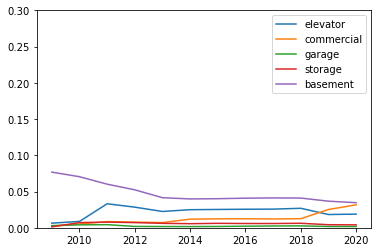

In [35]:
plt.axis([None, None, 0, 0.3])
plt.plot(years, [feature_importances[i][5:10] for i in range(len(feature_importances))])
plt.legend(cov_forest[5:10])

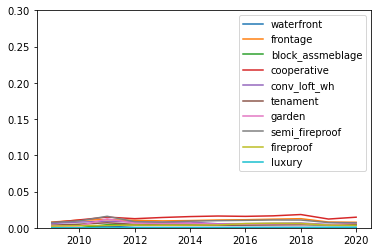

In [36]:
plt.axis([None, None, 0, 0.3])
plt.plot(years, [feature_importances[i][10:20] for i in range(len(feature_importances))])
plt.legend(cov_forest[10:20])

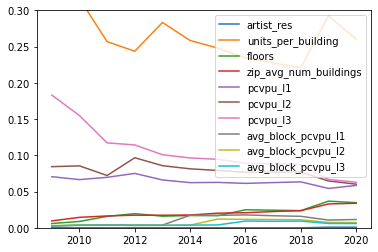

In [37]:
plt.axis([None, None, 0, 0.3])

plt.plot(years, [feature_importances[i][20:30] for i in range(len(feature_importances))])
plt.legend(cov_forest[20:30])

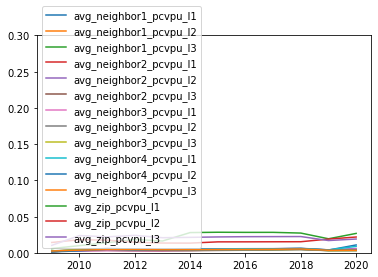

In [38]:
plt.axis([None, None, 0, 0.3])
plt.plot(years, [feature_importances[i][30:] for i in range(len(feature_importances))])
plt.legend(cov_forest[30:])